## Attention Only Classification Analysis

In [2]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import keras
from keras import backend as K
import tensorflow as tf

import os
import numpy as np
import pandas as pd
import scipy

import Bio
from Bio import SeqIO
import Bio.motifs

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import model_selection
import sklearn

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from signal_models import *
from utility_functions import *

sns.set_context('notebook')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
working_directory = '/home/jtao/analysis/genomic_grammar_analysis/'

## Read Data

In [5]:
treatment_positive_fasta_dict = {}
treatment_negative_fasta_dict = {}
treatment_positive_seqArray_dict = {}
treatment_positive_rc_seqArray_dict = {}
treatment_negative_seqArray_dict = {}
treatment_negative_rc_seqArray_dict = {}

for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    treatment = ps.split('_')[1]
    print('***',treatment, '***')
    positive_seqRecords = list(SeqIO.parse(working_directory + '/peak_sequences/' + ps, 'fasta'))
    negative_seqRecords = list(SeqIO.parse(working_directory + '/background_files/' + ps.replace('_peaks', '_background'), 'fasta'))[:len(positive_seqRecords)]
    
    positive_fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords]
    negative_fasta_seq = [str(x.seq[:200]) for x in negative_seqRecords]
    
    positive_rc_fasta_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords]
    negative_rc_fasta_seq = [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]
    
    positive_sequence_arrays = convert_sequences_to_array(positive_fasta_seq)
    positive_rc_sequence_arrays = convert_sequences_to_array(positive_rc_fasta_seq)
    
    negative_sequence_arrays = convert_sequences_to_array(negative_fasta_seq)
    negative_rc_sequence_arrays = convert_sequences_to_array(negative_rc_fasta_seq)
    
    treatment_positive_fasta_dict[treatment] = positive_fasta_seq
    treatment_negative_fasta_dict[treatment] = negative_fasta_seq
    treatment_positive_seqArray_dict[treatment] = positive_sequence_arrays
    treatment_positive_rc_seqArray_dict[treatment] = positive_rc_sequence_arrays
    treatment_negative_seqArray_dict[treatment] = negative_sequence_arrays
    treatment_negative_rc_seqArray_dict[treatment] = negative_rc_sequence_arrays

*** kla-1h ***
*** veh ***
*** il4-24h ***


## Set Model Settings

In [356]:
### settings for attention model ###
attention_num_motifs=128
attention_motif_size=10
adjacent_bp_pool_size=1
attention_num_dense_neurons = 8
attention_dropout_rate=0.1

### settings for convolution model ###
convolution_num_motifs=16
convolution_motif_size=24
num_dense_neurons=32
convolution_dropout_rate=0.5

largeConvolution_num_motifs = 50
large_num_dense_neurons = 100

In [357]:
dotProductAttention_model = get_dotProductAttention_model(200,
    mode='classification',
    num_motifs=attention_num_motifs, 
    motif_size=attention_motif_size,
    adjacent_bp_pool_size=adjacent_bp_pool_size,
    num_dense_neurons = attention_num_dense_neurons,
    dropout_rate=attention_dropout_rate,
    num_classes=2)
print('dotProductAttention_model', dotProductAttention_model.count_params())

convolution_model = get_convolution_model(200,
    mode='classification',
    num_motifs=convolution_num_motifs, 
    motif_size=convolution_motif_size,
    num_dense_neurons=num_dense_neurons,
    dropout_rate=convolution_dropout_rate,
    num_classes=2)
print('convolution_model', convolution_model.count_params())

large_convolution_model = get_convolution_model(200,
    mode='classification',
    num_motifs=largeConvolution_num_motifs, 
    motif_size=convolution_motif_size,
    num_dense_neurons=large_num_dense_neurons,
    dropout_rate=convolution_dropout_rate,
    num_classes=2)
print('large_convolution_model', large_convolution_model.count_params())



dotProductAttention_model 9866
convolution_model 2162
large_convolution_model 10152


## Train All Models for all Data Sets

In [ ]:
# condition_model_dict = {}

In [ ]:
num_epochs = 20
all_rocs = []
all_accuracies = []
all_precisions = []
all_treatments = []
model_types = []
parameter_counts = []
iteration_list = []

train_dotAttention = True
train_convolution = True
train_large_convolution = True
for iteration in range(1,4):
    print('iteration', iteration)
    for treatment in treatment_positive_fasta_dict:
        positive_sequence_arrays = treatment_positive_seqArray_dict[treatment] 
        positive_rc_sequence_arrays = treatment_positive_rc_seqArray_dict[treatment]
        negative_sequence_arrays = treatment_negative_seqArray_dict[treatment]
        negative_rc_sequence_arrays = treatment_negative_rc_seqArray_dict[treatment]

        sequence_arrays = np.concatenate([positive_sequence_arrays, negative_sequence_arrays])
        sequence_rc_arrays = np.concatenate([positive_rc_sequence_arrays, negative_rc_sequence_arrays])
        labels = [1 for x in positive_sequence_arrays] + [0 for x in negative_sequence_arrays]
        labels = np.array(labels)

        x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(
            sequence_arrays, 
            sequence_rc_arrays, 
            labels, 
            test_size=0.2)

        num_classes = 2
        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)

        ### dot product attention model ###
        if train_dotAttention:
            print('Training DotAttention', treatment)
            dotProductAttention_model = get_dotProductAttention_model(200,
                mode='classification',
                num_motifs=attention_num_motifs, 
                motif_size=attention_motif_size,
                adjacent_bp_pool_size=adjacent_bp_pool_size,
                dropout_rate=attention_dropout_rate,
                num_classes=2)

            dotProductAttention_model.fit([x_train], y_train,
                      batch_size=64,
                      epochs=num_epochs,
                      verbose=1,
                      validation_data=([x_test], y_test))

            probs = dotProductAttention_model.predict([x_test])
            test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
            roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
            precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
            acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
            param_count = dotProductAttention_model.count_params()

            all_rocs.append(roc)
            all_accuracies.append(acc)
            all_precisions.append(precision)
            all_treatments.append(treatment)
            model_types.append('DotAttention')
            parameter_counts.append(param_count)
            iteration_list.append(iteration)
            condition_model_dict['DotAttention_'+treatment] = dotProductAttention_model
        ### ###

        ### large convolution model ###
        if train_large_convolution:
            print('Training Large Convolution', treatment)
            large_convolution_model = get_convolution_model(200,
                mode='classification',
                num_motifs=largeConvolution_num_motifs, 
                motif_size=convolution_motif_size,
                num_dense_neurons=large_num_dense_neurons,
                dropout_rate=convolution_dropout_rate,
                num_classes=2)
            large_convolution_model.fit([x_train, x_rc_train], y_train,
                      batch_size=64,
                      epochs=num_epochs,
                      verbose=1,
                      validation_data=([x_test, x_rc_test], y_test))

            probs = large_convolution_model.predict([x_test, x_rc_test])
            test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
            roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
            precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
            acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
            param_count = convolution_model.count_params()

            all_rocs.append(roc)
            all_accuracies.append(acc)
            all_precisions.append(precision)
            all_treatments.append(treatment)
            model_types.append('LargeConvolution')
            parameter_counts.append(param_count)
            iteration_list.append(iteration)
            condition_model_dict['LargeConvolution_'+treatment] = large_convolution_model

        ### convolution model ###
        if train_convolution:
            print('Training Convolution', treatment)
            convolution_model = get_convolution_model(200,
                mode='classification',
                num_motifs=convolution_num_motifs, 
                motif_size=convolution_motif_size,
                num_dense_neurons=num_dense_neurons,
                dropout_rate=convolution_dropout_rate,
                num_classes=2)
            convolution_model.fit([x_train, x_rc_train], y_train,
                      batch_size=64,
                      epochs=num_epochs,
                      verbose=1,
                      validation_data=([x_test, x_rc_test], y_test))

            probs = convolution_model.predict([x_test, x_rc_test])
            test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
            roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
            precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
            acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
            param_count = convolution_model.count_params()

            all_rocs.append(roc)
            all_accuracies.append(acc)
            all_precisions.append(precision)
            all_treatments.append(treatment)
            model_types.append('Convolution')
            parameter_counts.append(param_count)
            iteration_list.append(iteration)
            condition_model_dict['Convolution_'+treatment] = convolution_model

iteration 1
Training DotAttention kla-1h
Train on 34841 samples, validate on 8711 samples
Epoch 1/20
34841/34841 [==============================] - 76s 2ms/step - loss: 0.6656 - categorical_accuracy: 0.5753 - val_loss: 0.6093 - val_categorical_accuracy: 0.6613
Epoch 2/20
34841/34841 [==============================] - 42s 1ms/step - loss: 0.5875 - categorical_accuracy: 0.6887 - val_loss: 0.5644 - val_categorical_accuracy: 0.7091
Epoch 3/20
34841/34841 [==============================] - 42s 1ms/step - loss: 0.5398 - categorical_accuracy: 0.7328 - val_loss: 0.5035 - val_categorical_accuracy: 0.7540
Epoch 4/20
34841/34841 [==============================] - 43s 1ms/step - loss: 0.5003 - categorical_accuracy: 0.7576 - val_loss: 0.4865 - val_categorical_accuracy: 0.7686
Epoch 5/20
 8960/34841 [======>.......................] - ETA: 26s - loss: 0.4826 - categorical_accuracy: 0.7699

In [ ]:
performance_frame = pd.DataFrame({'Model Type': model_types, 
                                  'Treatment':all_treatments,
                                  'Accuracy':all_accuracies, 
                                  'aucROC':all_rocs,
                                  'Precision':all_precisions})

In [ ]:
performance_frame.to_csv(working_directory + '/figures/performance.tsv', sep='\t')

In [350]:
performance_frame

,Accuracy,Model Type,Precision,Treatment,aucROC
0,0.843187,DotAttention,0.865518,kla-1h,0.910570
1,0.834462,LargeConvolution,0.831663,kla-1h,0.910575
2,0.824590,Convolution,0.811276,kla-1h,0.900819
3,0.850475,DotAttention,0.874893,veh,0.916886
4,0.850872,LargeConvolution,0.845426,veh,0.925021
5,0.832409,Convolution,0.820430,veh,0.911115
6,0.851208,DotAttention,0.807849,il4-24h,0.916746
7,0.843750,LargeConvolution,0.798746,il4-24h,0.927636
8,0.825776,Convolution,0.816998,il4-24h,0.904614


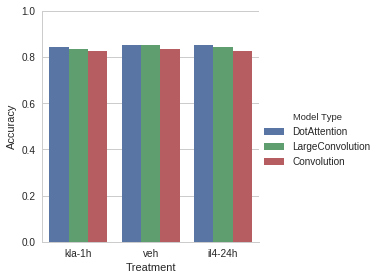

In [347]:
with sns.axes_style('whitegrid'):
    sns.factorplot(data = performance_frame,
        x = 'Treatment', 
        y = 'Accuracy',
        hue = 'Model Type',
        kind = 'bar'
        )
    plt.ylim(0,1)

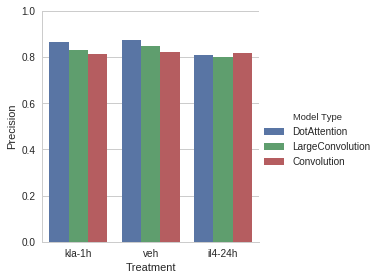

In [348]:
with sns.axes_style('whitegrid'):
    sns.factorplot(data = performance_frame,
        x = 'Treatment', 
        y = 'Precision',
        hue = 'Model Type',
        kind = 'bar'
        )
    plt.ylim(0,1)

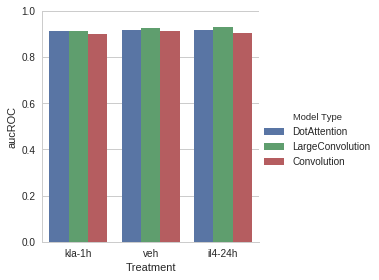

In [349]:
with sns.axes_style('whitegrid'):
    sns.factorplot(data = performance_frame,
        x = 'Treatment', 
        y = 'aucROC',
        hue = 'Model Type',
        kind = 'bar'
        )
    plt.ylim(0,1)

## Serialize Models

In [251]:
if len(condition_model_dict) > 0:
    if not os.path.isdir(working_directory + '/models_classification'):
        os.mkdir(working_directory + '/models_classification')
    else:
        for f in os.listdir(working_directory + '/models_classification'):
            os.remove(working_directory + '/models_classification/' + f)
    for treatment_modelType in condition_model_dict.keys():
        current_model = condition_model_dict[treatment_modelType]
        current_model.save_weights(working_directory + '/models_classification/' + treatment_modelType + '_weights.h5',
                          )

## Read in Models

In [252]:
condition_model_dict = {}
for f in os.listdir(working_directory + '/models_classification/'):
    treatment_modelType = f.replace('_weights.h5','')
    modelType = treatment_modelType.split('_')[0]    
    if modelType == 'DotAttention':
        current_model = get_dotProductAttention_model(200,
            mode='classification',
            num_motifs=attention_num_motifs, 
            motif_size=attention_motif_size,
            adjacent_bp_pool_size=adjacent_bp_pool_size,
            num_dense_neurons = attention_num_dense_neurons,
            dropout_rate=attention_dropout_rate,
            num_classes=2)
    elif modelType == 'Convolution':
        current_model = get_convolution_model(200,
            mode='classification',
            num_motifs=convolution_num_motifs, 
            motif_size=convolution_motif_size,
            num_dense_neurons=num_dense_neurons,
            dropout_rate=convolution_dropout_rate,
            num_classes=2)
    elif modelType == 'LargeConvolution':
        current_model = get_convolution_model(200,
            mode='classification',
            num_motifs= largeConvolution_num_motifs, 
            motif_size=convolution_motif_size,
            num_dense_neurons=large_num_dense_neurons,
            dropout_rate=convolution_dropout_rate,
            num_classes=2)
    current_model.load_weights(working_directory + '/models_classification/' + treatment_modelType + '_weights.h5',
                              )
    condition_model_dict[treatment_modelType] = current_model

## Grid Search for Dot Product Attention Model

In [ ]:
all_rocs = []
all_accuracies = []
all_precisions = []
poolSize_list = []
all_treatments = []
motifCount_list = []
numDense_list = []
paramCount_list = []
dropoutRate_list = []
num_epochs = 10
for treatment in treatment_positive_fasta_dict:
    positive_sequence_arrays = treatment_positive_seqArray_dict[treatment] 
    positive_rc_sequence_arrays = treatment_positive_rc_seqArray_dict[treatment]
    negative_sequence_arrays = treatment_negative_seqArray_dict[treatment]
    negative_rc_sequence_arrays = treatment_negative_rc_seqArray_dict[treatment]

    sequence_arrays = np.concatenate([positive_sequence_arrays, negative_sequence_arrays])
    sequence_rc_arrays = np.concatenate([positive_rc_sequence_arrays, negative_rc_sequence_arrays])
    labels = [1 for x in positive_sequence_arrays] + [0 for x in negative_sequence_arrays]
    labels = np.array(labels)

    x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(
        sequence_arrays, 
        sequence_rc_arrays, 
        labels, 
        test_size=0.2)

    num_classes = 2
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)    
    
    for d in [6, 12]:
        for m in [150]:
            for p in [1]:
                for do in [0.1,0.5]:
                    
                    current_model = get_dotProductAttention_model(200,
                        mode='classification',
                        num_classes = 2,
                        num_motifs=m, 
                        motif_size=10,
                        adjacent_bp_pool_size=p,
                        num_dense_neurons=d,
                        dropout_rate=do)
                    num_params = current_model.count_params()
                    print(treatment, 
                         'num dense', d,
                         'num motifs', m,
                         'pool size', p,
                         'dropout rate', do,
                         'param count', num_params)
                    current_model.fit(x_train, y_train,
                          batch_size=64,
                          epochs=num_epochs,
                          verbose=1,
                          validation_data=([x_test], y_test))

                    probs = current_model.predict([x_test])
                    test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
                    roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1])
                    precision = sklearn.metrics.precision_score([y[1] for y in y_test], test_predictions)
                    acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
                    
                    all_rocs.append(roc)
                    all_accuracies.append(acc)
                    all_precisions.append(precision)
                    poolSize_list.append(p)
                    all_treatments.append(treatment)
                    motifCount_list.append(m)
                    numDense_list.append(d)
                    paramCount_list.append(num_params)
                    dropoutRate_list.append(do)

kla-1h num dense 6 num motifs 150 pool size 1 dropout rate 0.1 param count 9908
Train on 34841 samples, validate on 8711 samples
Epoch 1/10
34841/34841 [==============================] - 54s 2ms/step - loss: 0.6681 - categorical_accuracy: 0.5710 - val_loss: 0.6224 - val_categorical_accuracy: 0.6448
Epoch 2/10
34841/34841 [==============================] - 38s 1ms/step - loss: 0.5831 - categorical_accuracy: 0.6948 - val_loss: 0.5474 - val_categorical_accuracy: 0.7262
Epoch 3/10
34841/34841 [==============================] - 38s 1ms/step - loss: 0.5461 - categorical_accuracy: 0.7246 - val_loss: 0.6034 - val_categorical_accuracy: 0.6772
Epoch 4/10
34841/34841 [==============================] - 38s 1ms/step - loss: 0.5148 - categorical_accuracy: 0.7471 - val_loss: 0.4873 - val_categorical_accuracy: 0.7680
Epoch 5/10
34841/34841 [==============================] - 38s 1ms/step - loss: 0.4893 - categorical_accuracy: 0.7640 - val_loss: 0.4733 - val_categorical_accuracy: 0.7803
Epoch 6/10
34841

In [199]:
performance_frame = pd.DataFrame({'aucROC':all_rocs, 
                      'Accuracy':all_accuracies, 
                      'Pool Size':poolSize_list, 
                      'Precision':all_precisions,
                      'Treatment':all_treatments,
                      'Num Motifs':motifCount_list,
                      'Num Dense':numDense_list,
                      'Num Params':paramCount_list,
                      'Dropout Rate':dropoutRate_list
                      })

In [200]:
performance_frame.to_csv('./grid_search_results.tsv', sep='\t')

In [201]:
performance_frame[performance_frame['Treatment'] == 'kla-1h'].sort_values('aucROC',ascending = False).head()

,Accuracy,Dropout Rate,Num Dense,Num Motifs,Num Params,Pool Size,Precision,Treatment,aucROC
2,0.838021,0.1,12,150,13214,1,0.832573,kla-1h,0.908437
3,0.818391,0.5,12,150,13214,1,0.860331,kla-1h,0.890596
0,0.808174,0.1,6,150,9908,1,0.863836,kla-1h,0.888792
1,0.833199,0.5,6,150,9908,1,0.832331,kla-1h,0.883614


In [202]:
performance_frame[performance_frame['Treatment'] == 'il4-24h'].sort_values('aucROC',ascending = False).head()

,Accuracy,Dropout Rate,Num Dense,Num Motifs,Num Params,Pool Size,Precision,Treatment,aucROC
11,0.835844,0.5,12,150,13214,1,0.885327,il4-24h,0.909909
10,0.848896,0.1,12,150,13214,1,0.850312,il4-24h,0.900551
8,0.790946,0.1,6,150,9908,1,0.921497,il4-24h,0.898482
9,0.848300,0.5,6,150,9908,1,0.867051,il4-24h,0.873665


In [203]:
performance_frame[performance_frame['Treatment'] == 'veh'].sort_values('aucROC',ascending = False).head()

,Accuracy,Dropout Rate,Num Dense,Num Motifs,Num Params,Pool Size,Precision,Treatment,aucROC
6,0.856973,0.1,12,150,13214,1,0.842089,veh,0.921300
5,0.851506,0.5,6,150,9908,1,0.847799,veh,0.921128
4,0.851506,0.1,6,150,9908,1,0.835456,veh,0.918767
7,0.814659,0.5,12,150,13214,1,0.912654,veh,0.911097


(0.8, 0.9)

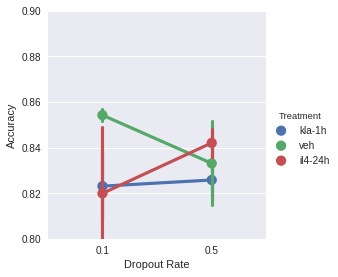

In [207]:
sns.factorplot(data = performance_frame, x = 'Dropout Rate', y='Accuracy', hue = 'Treatment')
plt.ylim(0.8,0.9)

(0.8, 0.9)

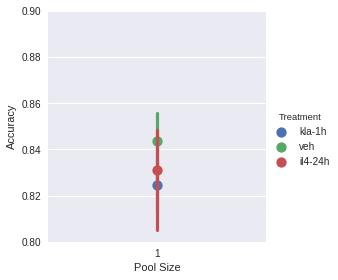

In [205]:
sns.factorplot(data = performance_frame, x = 'Pool Size', y='Accuracy', hue = 'Treatment')
plt.ylim(0.8,0.9)

(0.8, 0.9)

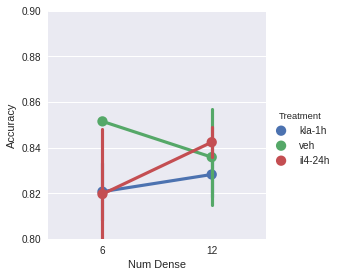

In [208]:
sns.factorplot(data = performance_frame, x = 'Num Dense', y='Accuracy', hue = 'Treatment')
plt.ylim(0.8,0.9)

## Weight Extraction

In [549]:
def get_sequence_attention(model, sequence_arrays, sequence_size, adjacent_bp_pool_size):
    get_attention = K.function([model.get_layer('input_fwd').input, 
                                K.learning_phase()
                               ], 
                               [model.get_layer('attention_softmax_layer').output])
    trimmed_sequences = [x[:sequence_size] for x in sequence_arrays]
    
    attention = get_attention((trimmed_sequences, 0))[0]

    return attention

In [550]:
treatment_attention_dict = {}
for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    treatment = ps.split('_')[1]
    print('***',treatment, '***')
    fasta_seq = treatment_positive_fasta_dict[treatment]
    
    sequence_arrays = treatment_positive_seqArray_dict[treatment]
    if 'DotAttention_'+treatment in condition_model_dict:
        current_model = condition_model_dict['DotAttention_'+treatment]

        attention = get_sequence_attention(current_model,
            sequence_arrays,
            200,
            10)

        treatment_attention_dict[treatment] = attention


*** kla-1h ***
*** veh ***
*** il4-24h ***


## Visualize Attention

### Overall Matrix

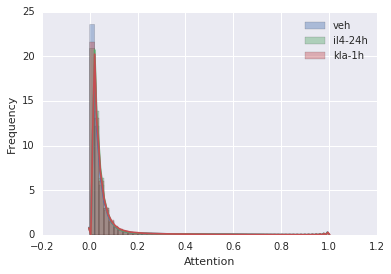

In [551]:
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    sns.distplot(treatment_attention.flatten(), label = treatment)
plt.xlabel('Attention')
plt.ylabel('Frequency')
plt.legend()

#### Per sequence frequencies

In [552]:
num_positions = 20
matrix_size = num_positions**2
count_list = []
treatment_list = []
threshold_list = []
normalized_count_list = []
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    print(treatment)
    for threshold in [np.round(x,2) for x in np.arange(0.1,1,0.05)]:
        for am in treatment_attention:
            count = np.sum(am.flatten() > threshold)
            count_list.append(count)
            normalized_count_list.append(count/matrix_size)
            treatment_list.append(treatment)
            threshold_list.append(threshold)
        


veh
il4-24h
kla-1h


In [553]:
frame = pd.DataFrame({'Treatment': treatment_list, 
                      'Threshold': threshold_list,
                      'Count':count_list,
                      'Normalized Count':normalized_count_list})

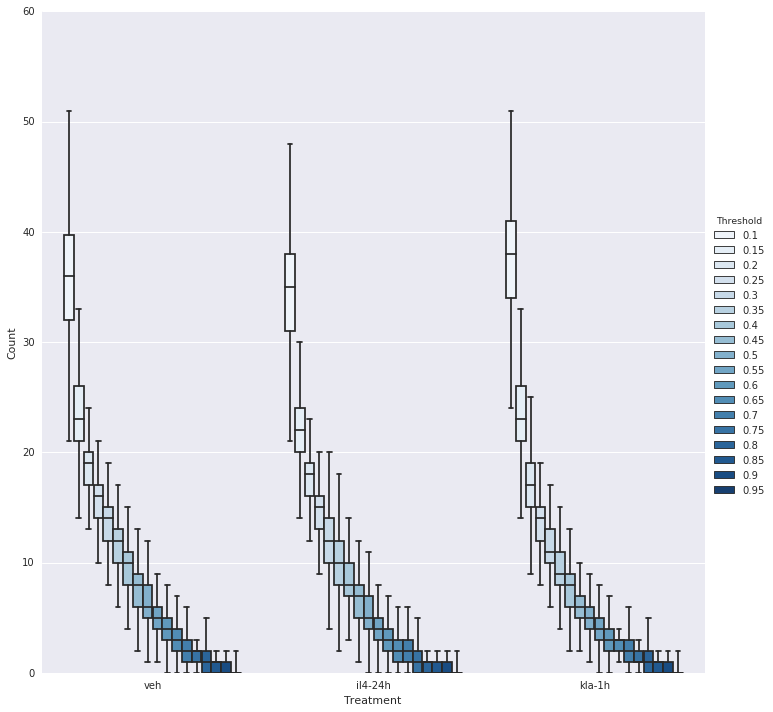

In [554]:
sns.factorplot(data = frame, 
    x = 'Treatment',
    y = 'Count',
    hue='Threshold',
    kind = 'box',
    palette = 'Blues',
    showfliers=False,
    size = 10)

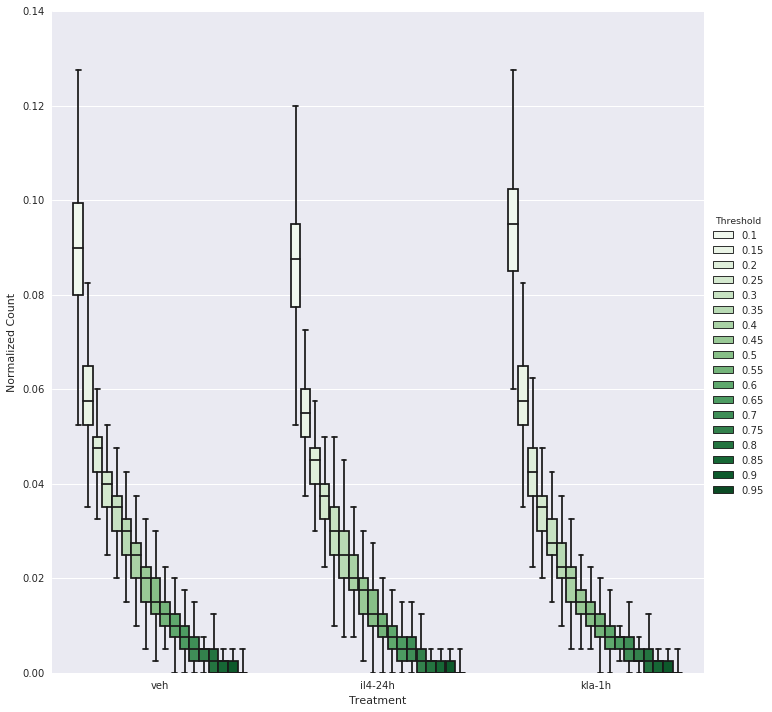

In [555]:
sns.factorplot(data = frame, 
    x = 'Treatment',
    y = 'Normalized Count',
    hue='Threshold',
    kind = 'box',
    palette = 'Greens',
    showfliers=False,
    size = 10)

### Max per Position

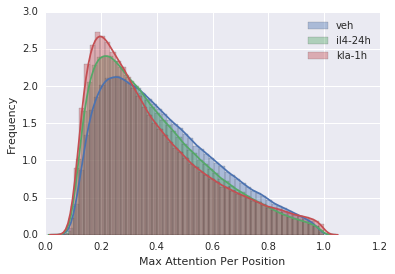

In [637]:
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    max_attention = np.array([x.max(axis=0) for x in treatment_attention])
    sns.distplot(max_attention.flatten(), label = treatment)
plt.xlabel('Max Attention Per Position')
plt.ylabel('Frequency')
plt.legend()

#### Per sequence frequencies

In [638]:
num_positions = 20
count_list = []
treatment_list = []
threshold_list = []
normalized_count_list = []
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    max_attention = np.array([x.max(axis=0) for x in treatment_attention])
    print(treatment)
    for threshold in [np.round(x,2) for x in np.arange(0.1,1,0.1)]:
        for fam in max_attention:
            count = np.sum(fam.flatten() >= threshold)
            count_list.append(count)
            normalized_count_list.append(count/num_positions)
            treatment_list.append(treatment)
            threshold_list.append(threshold)
        


veh
il4-24h
kla-1h


In [639]:
frame = pd.DataFrame({'Treatment': treatment_list, 
                      'Threshold': threshold_list,
                      'Count':count_list,
                      'Normalized Count':normalized_count_list})

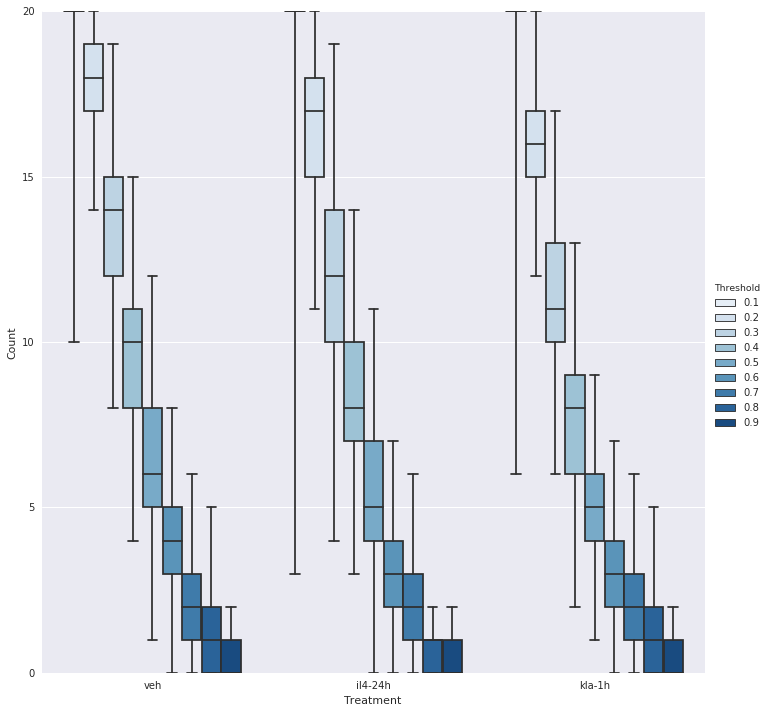

In [640]:
sns.factorplot(data = frame, 
    x = 'Treatment',
    y = 'Count',
    hue='Threshold',
    kind = 'box',
    palette = 'Blues',
    showfliers=False,
    size = 10)


## Per k-mer attention analysis

### K-mers observed

In [573]:
print(4**10, '10-mers possible')

1048576 10-mers possible


In [574]:
kmer_size = 10
sequence_size = 200

for treatment in treatment_positive_fasta_dict:
    kmer_set = set()
    print('***',treatment, '***')

    fasta_seq = treatment_positive_fasta_dict[treatment]
    for seq in fasta_seq:
        for i in range(0,sequence_size-kmer_size):
            kmer = seq[i:i+kmer_size]
            kmer_set.add(kmer)
    print(len(kmer_set), '10-mers observed')   

*** veh ***
917179 10-mers observed
*** il4-24h ***
918403 10-mers observed
*** kla-1h ***
852757 10-mers observed


### Attention Accumulated by each 10-mer

#### Total

In [641]:
kmer_size = 10
sequence_size = 200
count_list = []
treatment_list = []
threshold_list = []
normalized_count_list = []
treatment_maxAttention_dict = {}
for treatment in treatment_attention_dict:
    kmer_maxAttention_dict = {}
    treatment_attention = treatment_attention_dict[treatment]
    max_attention = np.array([x.max(axis=0) for x in treatment_attention])
    treatment_fasta = treatment_positive_fasta_dict[treatment]
    for ma, seq in zip(max_attention, treatment_fasta):
        for i in range(0,sequence_size,kmer_size): 
            for j in range(kmer_size):
#                 print(i+j, i+j+kmer_size)
#                 print(len(subseq))
                subseq = seq[i+j: i+j+kmer_size]
                if not subseq in kmer_maxAttention_dict:
                    kmer_maxAttention_dict[subseq] = ma[int(i/kmer_size)]
                else:
                    kmer_maxAttention_dict[subseq] += ma[int(i/kmer_size)]
    treatment_maxAttention_dict[treatment] = kmer_maxAttention_dict

veh
kla-1h
il4-24h


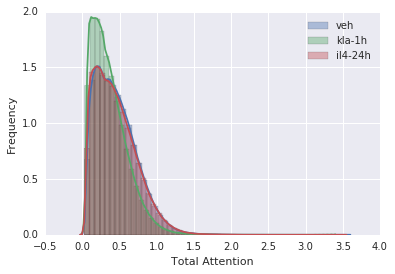

In [642]:
for treatment in treatment_maxAttention_dict:
    print(treatment)
    maxAttention = np.array(list(treatment_maxAttention_dict[treatment].values()))
    sns.distplot(np.log10(maxAttention+1), label = treatment)
plt.legend()
plt.xlabel('Total Attention')
plt.ylabel('Frequency')

#### Distribution

In [646]:
attention_threshold = 0.2
kmer_size = 10
sequence_size = 200
treatment_kmerAttendedCount_dict = {}
for treatment in treatment_attention_dict:
    kmer_attendedCount_dict = {}
    overall_counter = 0
    counter = 0
    treatment_attention = treatment_attention_dict[treatment]
    max_attention = np.array([x.max(axis=1) for x in treatment_attention])
    treatment_fasta = treatment_positive_fasta_dict[treatment]
    for fam, seq in zip(max_attention, treatment_fasta):
        for i in range(0,sequence_size,kmer_size): 
            for j in range(kmer_size):
                subseq = seq[i+j: i+j+kmer_size]
                att = fam[int(i/kmer_size)]
                overall_counter += 1
                if att >=attention_threshold:
                    counter +=1
                    if not subseq in kmer_attendedCount_dict:
                        kmer_attendedCount_dict[subseq] = 1
                    else:
                        kmer_attendedCount_dict[subseq] += 1
    print(treatment,counter, overall_counter)
    treatment_kmerAttendedCount_dict[treatment] = kmer_attendedCount_dict

veh 5294220 6310000
il4-24h 5340260 6703600
kla-1h 3200210 4355200


In [647]:
count_list = []
treatment_list = []
threshold_list = []
for treatment in treatment_kmerAttendedCount_dict:
    counts = np.array(list(treatment_kmerAttendedCount_dict[treatment].values()))
    fasta = treatment_positive_fasta_dict[treatment]
    for threshold in np.arange(0.005,0.05,0.005):
        rounded_threshold = np.round(threshold, 3)
        count_threshold = int(threshold*len(fasta))
        count = np.sum(counts > count_threshold)
        
        count_list.append(count)
        treatment_list.append(treatment)
        threshold_list.append(rounded_threshold)
frame = pd.DataFrame({'Treatment':treatment_list,
                      'Threshold':threshold_list,
                      'Count':count_list})        

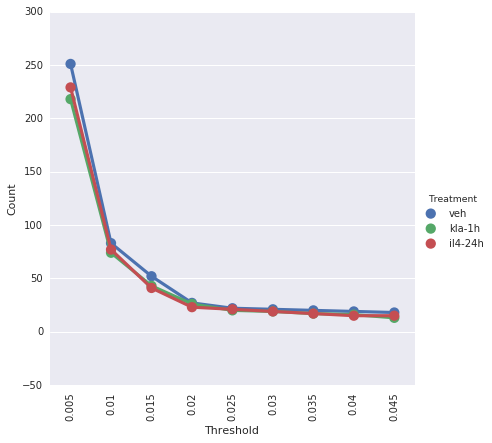

In [648]:
sns.factorplot(data = frame,
               x= 'Threshold',
               y = 'Count',
               hue = 'Treatment',
               size=6)
plt.xticks(rotation=90);

## Create K-mer network

In [653]:
ma

array([0.2172472 , 0.25620404, 0.20409442, 0.23104174, 0.4370355 ,
       0.59980595, 0.2668783 , 0.66884017, 0.7239828 , 0.21032847,
       0.4223705 , 0.71340513, 0.3015039 , 0.3440063 , 0.51151496,
       0.25276846, 0.53751236, 0.21890686, 0.22671384, 0.27361572],
      dtype=float32)

In [654]:
att

0.27361572

In [694]:
attention_threshold = 0.2
count_threshold = 100
kmer_size = 10
sequence_size = 200
kmer_count_dict = {}
for treatment in treatment_attention_dict:
    kmer_set = set()
    print(treatment)

    treatment_attention = treatment_attention_dict[treatment]
    max_attention = np.array([x.max(axis=1) for x in treatment_attention])
    treatment_fasta = treatment_positive_fasta_dict[treatment]
    
    for seq in treatment_fasta:

        for i in range(0,sequence_size,kmer_size): 
            for j in range(kmer_size):
                subseq = seq[i+j: i+j+kmer_size]
                if subseq in kmer_count_dict:
                    kmer_count_dict[subseq] += 1
                else:
                    kmer_count_dict[subseq] = 1
    count = 0
    for kmer in kmer_count_dict:
        if kmer_count_dict[kmer] > count_threshold:
            count+=1
    print(count)
    for ma, seq in zip(max_attention, treatment_fasta):
        for i in range(0,sequence_size,kmer_size): 
            for j in range(kmer_size):
                subseq = seq[i+j: i+j+kmer_size]
                att = ma[int(i/kmer_size)]
                if att>= attention_threshold and kmer_count_dict[subseq] > count_threshold and len(subseq) == kmer_size:
                    kmer_set.add(subseq)
    print(len(kmer_set))
    


veh
66
14
il4-24h
149
67
kla-1h
254
121


In [695]:
kmer_set

{'AAAAAAAAAA',
 'AAAAAAAAAG',
 'AAAAGAGGAA',
 'AAACAGGAAG',
 'AAAGAGGAAG',
 'AAAGGGGAAG',
 'AACAGGAAGT',
 'AAGAGGAAGC',
 'AAGAGGAAGT',
 'AAGGAGGAAG',
 'ACACACACAC',
 'ACAGGAAGTG',
 'ACTTCCTCCT',
 'ACTTCCTCTT',
 'ACTTCCTGTT',
 'AGAGAGAGAG',
 'AGAGGAAGTG',
 'AGCCCCGCCC',
 'AGGAAGGAAG',
 'AGGAAGTGAG',
 'AGGAGGAAGT',
 'AGGAGGAGGA',
 'AGGCCCCGCC',
 'AGGGCGGGGC',
 'AGGGGCGGGG',
 'AGGGGGCGGG',
 'CACACACACA',
 'CACTTCCTCC',
 'CACTTCCTCT',
 'CACTTCCTGT',
 'CAGGAAGTGA',
 'CCACTTCCTC',
 'CCCCACCCCC',
 'CCCCCCCCCC',
 'CCCCGCCCAC',
 'CCCCGCCCCC',
 'CCCCGCCCCG',
 'CCCCGCCCCT',
 'CCCCGCCCTC',
 'CCCCGCCTCC',
 'CCCCTCCCCC',
 'CCCGCCCCCG',
 'CCCGCCCCCT',
 'CCCGCCCCGC',
 'CCCGCCCCTC',
 'CCGCCCCGCC',
 'CCGCCGCCGC',
 'CCTCCCTCCC',
 'CCTCCTCCTC',
 'CGCCCCGCCC',
 'CGCCGCCGCC',
 'CGGCCCCGCC',
 'CGGCGGCGGC',
 'CGGGGCGGGG',
 'CGGGGGCGGG',
 'CTCACTTCCT',
 'CTCCTCCTCC',
 'CTCTCTCTCT',
 'CTTCCCCTTT',
 'CTTCCTCCTC',
 'CTTCCTCTTC',
 'CTTCCTCTTT',
 'CTTCCTGTTT',
 'CTTCCTTCCT',
 'GAAAAAAAAA',
 'GAAAGAGGAA',
 'GAAGAGGA

In [675]:
attention_threshold = 0.5
kmer_size = 10
sequence_size = 200
kmer_set = set()
for treatment in treatment_attention_dict:
    print(treatment)

    treatment_attention = treatment_attention_dict[treatment]
    max_attention = np.array([x.max(axis=1) for x in treatment_attention])
    treatment_fasta = treatment_positive_fasta_dict[treatment]
    

    break            


veh
658881


In [660]:
len(kmer_set)

658881

## Verifying Attention Calculation

In [607]:
dotProductAttention_model.summary()

In [501]:
def check_dot_product(model, sequence_array, sequence_size, adjacent_bp_pool_size):
    check_dot_product = K.function([model.get_layer('input_fwd').input, 
                                K.learning_phase()
                               ], 
                               [model.get_layer('attention_dropout').output,
                                model.get_layer('value_transformer').output,
                                model.get_layer('attending_layer').output])
    
    attention, value, attended_values = check_dot_product(([sequence_array], 0))
    
    attention = np.reshape(attention, newshape=(attention.shape[1], attention.shape[2]))
    value = np.reshape(value, newshape=(value.shape[1], value.shape[2]))
    attended_values = np.reshape(attended_values, newshape=(attended_values.shape[1], attended_values.shape[2]))
    return attention, value, attended_values

In [522]:
attention, value, attended_values = check_dot_product(dotProductAttention_model, positive_sequence_arrays[0], 200, 10)

In [523]:
attention.shape

(20, 20)

In [524]:
value.shape

(20, 150)

In [525]:
attended_values.shape

(20, 150)

In [529]:
np.round(np.dot(attention, value),2) == np.round(attended_values, 2)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [530]:
np.round(np.dot(attention.T, value),2) == np.round(attended_values, 2)

array([[ True, False, False, ...,  True, False,  True],
       [ True,  True, False, ..., False, False,  True],
       [ True, False, False, ..., False, False,  True],
       ...,
       [False,  True, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False]])

In [534]:
attention.sum(axis=0)

array([0.9999999 , 0.99999994, 1.        , 0.9999999 , 0.99999994,
       0.9999999 , 1.0000001 , 0.9999998 , 1.0000002 , 0.99999994,
       1.0000001 , 0.9999999 , 1.        , 0.99999994, 1.        ,
       0.99999994, 0.99999994, 0.9999999 , 1.0000001 , 1.0000001 ],
      dtype=float32)

In [46]:
dotProductAttention_model = get_dotProductAttention_model(200,
    mode='classification',
    num_motifs=150, 
    motif_size=10,
    adjacent_bp_pool_size=1,
    dropout_rate=attention_dropout_rate,
    num_classes=2)

attending axes 1 1 linear


In [47]:
dotProductAttention_model.count_params()

7153

In [48]:
dotProductAttention_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_fwd (InputLayer)          (None, 200, 4)       0                                            
__________________________________________________________________________________________________
convolution_layer (Conv1D)      (None, 200, 150)     6150        input_fwd[0][0]                  
__________________________________________________________________________________________________
sequence_pooling_layer (MaxPool (None, 200, 150)     0           convolution_layer[0][0]          
__________________________________________________________________________________________________
query_transformer (TimeDistribu (1, 200, 150)        150         sequence_pooling_layer[0][0]     
__________________________________________________________________________________________________
key_transf

In [ ]:
attention = get_sequence_attention(dotProductAttention_model,
    sequence_arrays,
    200,
    10)

In [741]:
attention.sum(axis=0)

array([[ 932.66064,  143.86938,  140.54317, ...,  149.96219,  149.36406,
         145.9877 ],
       [ 145.71825,  748.07996,  144.5017 , ...,  151.97997,  150.34529,
         145.62857],
       [ 137.96504,  140.63329,  587.09094, ...,  148.31244,  146.35565,
         142.3505 ],
       ...,
       [ 156.54688,  157.0207 ,  158.11182, ...,  844.11145,  151.25342,
         138.96304],
       [ 158.80832,  158.16861,  159.03499, ...,  155.32713, 1205.9181 ,
         155.37332],
       [ 169.20193,  166.59555,  167.8357 , ...,  156.74983,  170.8072 ,
        1888.0425 ]], dtype=float32)

In [743]:
attention.shape

(33518, 200, 200)

In [748]:
all_attention_vals = attention.flatten()
nonzero_attention = all_attention_vals[all_attention_vals>0]

In [755]:
np.sum(all_attention_vals>0.1)

222662

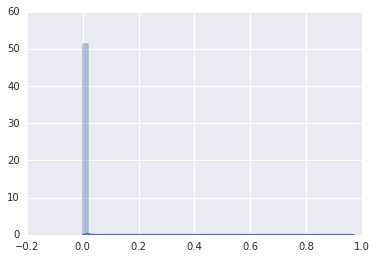

In [747]:
sns.distplot(attention.flatten())

In [752]:
len(attention.flatten())

1340720000

In [751]:
len(nonzero_attention)

1340720000

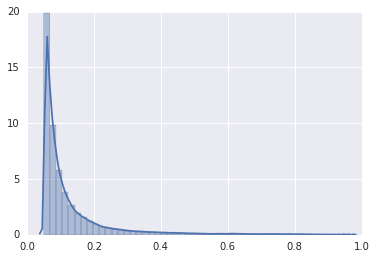

In [757]:
sns.distplot(all_attention_vals[all_attention_vals>0.05])